In [1]:
import pandas as pd

data_mpg = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original",
    delim_whitespace=True,
    header=None,
    names=[
        "mpg",
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "model year",
        "origin",
        "car name",
    ],
)

data_mpg.dropna(inplace=True)
data_mpg.drop(["model year", "origin", "car name"], axis=1, inplace=True)

/var/folders/5d/bg50v_hd3b90vwxc83124gt00000gn/T/ipykernel_91721/963688916.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_mpg = pd.read_csv(


In [2]:
from magpy.search.astar import AStarSearch
from magpy.search.astar import bic_score_node
import networkx as nx
import numpy
from sklearn.preprocessing import PolynomialFeatures


from typing import Optional


def my_custom_scoring_function(
    y: numpy.ndarray,
    X: Optional[numpy.ndarray] = None,
    node: Optional[str] = None,
    parent_set: Optional[set] = None,
):
    n = len(y)

    if X is None:
        residual = numpy.sum(y**2)
        dof = 0

    else:
        n, dof = X.shape
        _, residual, _, _ = numpy.linalg.lstsq(a=X, b=y, rcond=None)

    bic = n * numpy.log(residual / n) + dof * numpy.log(n)
    return bic.item()


def my_cross_validation_score(y, X, node, parent_set):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestRegressor

    if X is None:
        X = numpy.ones((len(y), 1))
    else:
        X = numpy.column_stack([X, numpy.ones(len(y))])

    model = RandomForestRegressor(n_estimators=100, max_depth=3)
    scores = cross_val_score(
        model, X, y.ravel(), cv=5, scoring="neg_mean_squared_error"
    )
    return -scores.mean()

/Users/andre/magpy/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 192/192 [01:28<00:00,  2.17it/s]


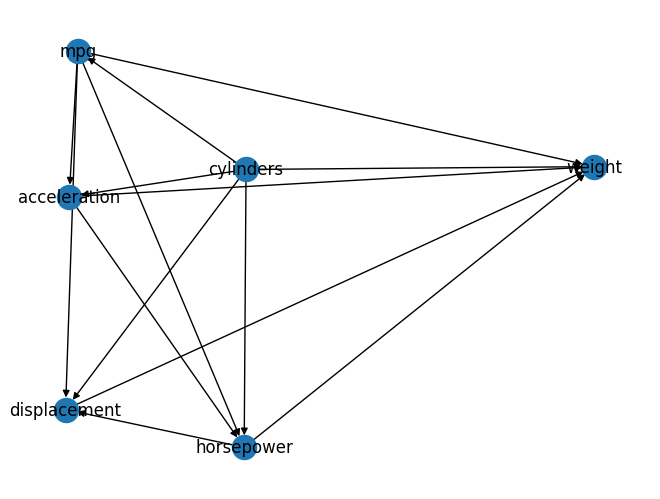

In [3]:
data = data_mpg.copy()
data = (data - data.mean()) / data.std()

astar = AStarSearch(data_mpg)
astar.run_scoring(func=my_cross_validation_score, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

In [6]:
astar.parent_graph.graph

{'mpg': [{'node': 'mpg',
   'parent_set': {'displacement', 'horsepower'},
   'score': np.float64(19.87859372866998)},
  {'node': 'mpg',
   'parent_set': {'acceleration', 'displacement', 'horsepower'},
   'score': np.float64(20.031211998001503)},
  {'node': 'mpg',
   'parent_set': {'cylinders', 'displacement', 'horsepower'},
   'score': np.float64(20.078416087891714)},
  {'node': 'mpg',
   'parent_set': {'acceleration', 'cylinders', 'displacement', 'horsepower'},
   'score': np.float64(20.2144492818683)},
  {'node': 'mpg',
   'parent_set': {'acceleration', 'cylinders', 'horsepower'},
   'score': np.float64(20.375444899152733)},
  {'node': 'mpg',
   'parent_set': {'cylinders', 'horsepower'},
   'score': np.float64(20.54898733266692)},
  {'node': 'mpg',
   'parent_set': {'cylinders', 'displacement', 'horsepower', 'weight'},
   'score': np.float64(21.412561633213826)},
  {'node': 'mpg',
   'parent_set': {'displacement', 'horsepower', 'weight'},
   'score': np.float64(21.613654794692188)},


100%|██████████| 160/160 [00:00<00:00, 355.85it/s]


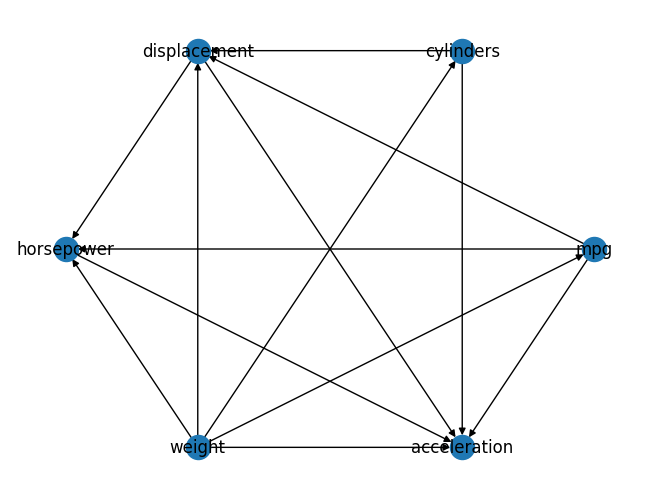

In [8]:
# let's also include the fact that weight is leading to MPG

include_graph = pd.DataFrame(0, index=data_mpg.columns, columns=data_mpg.columns)
include_graph.loc["weight", "mpg"] = 1
include_graph.loc["weight", "cylinders"] = 1

astar = AStarSearch(data_mpg, include_graph=include_graph)
astar.run_scoring(func=bic_score_node, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)

In [20]:
from magpy.oracles.oracles import BaseOracle, linear

In [21]:
oracle = BaseOracle(data_mpg, learner=linear)

In [25]:
oracle._run("mpg", "weight")

np.float64(1.1102230246251565e-16)

In [3]:
from causallearn.utils.Dataset import load_dataset

data_sachs, labels = load_dataset("sachs")

In [4]:
df = pd.DataFrame(data_sachs, columns=labels)

In [5]:
astar = AStarSearch(df)
astar.run_scoring(func=bic_score_node, parallel=True)
mat = astar.search()
G = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)

  0%|          | 4/11264 [00:00<12:26, 15.08it/s]

KeyboardInterrupt: 

In [19]:
from magpy.oracles.oracles import linear, BaseOracle


z = numpy.random.normal(0, 1, size=1000)
x = z + numpy.random.normal(0, 1, size=1000)
y = z + numpy.random.normal(0, 1, size=1000)
df = pd.DataFrame({"x": x, "y": y, "z": z})


oracle = BaseOracle(df, learner=linear, rank=False)
oracle._run("x", "y", [])

np.float64(1.1102230246251565e-16)

In [43]:
linear

<function magpy.oracles.oracles.linear(X, y, node: Optional[str] = None, parent_set: Optional[set] = None)>

In [11]:
from scipy.stats import pearsonr

In [12]:
pearsonr(df["raf"], df["jnk"])

PearsonRResult(statistic=np.float64(0.19268868803436862), pvalue=np.float64(2.2666218076955302e-63))

In [45]:
from magpy.oracles.oracles import CausalLearnOracle

oracle = CausalLearnOracle(df, "kci")

In [47]:
oracle("raf", "jnk", ["pka"])